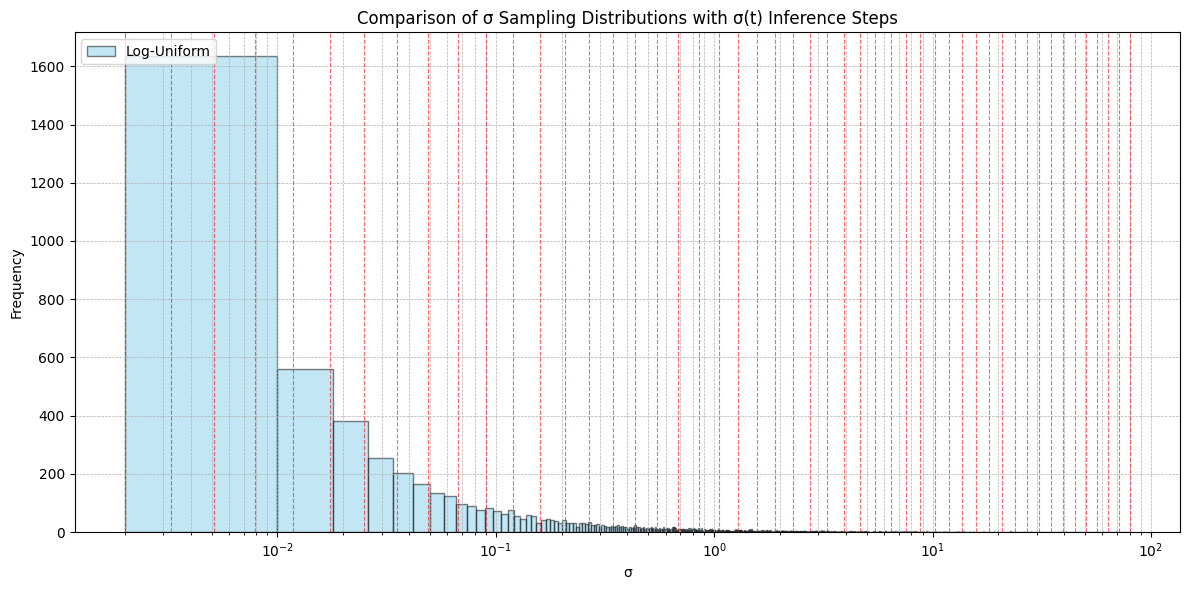

In [35]:
import torch
import matplotlib.pyplot as plt

# ------------------------------------------
# 하이퍼파라미터 및 t_steps 계산
inference_time_step = 50
sigma_min = 0.002
sigma_max = 80
rho = 7.0

step_indices = torch.arange(inference_time_step)
sigma_min_rho = sigma_min ** (1 / rho)
sigma_max_rho = sigma_max ** (1 / rho)
t_steps = (sigma_max_rho + step_indices / (inference_time_step - 1) * (sigma_min_rho - sigma_max_rho)) ** rho
t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
t_steps_np = t_steps.numpy()

# ------------------------------------------
# 샘플링 분포 생성
num_samples = 10000
# Log-Uniform
log_sigma_min = torch.log(torch.tensor(sigma_min))
log_sigma_max = torch.log(torch.tensor(sigma_max))
log_sigma_uniform = torch.rand(num_samples) * (log_sigma_max - log_sigma_min) + log_sigma_min
sigma_uniform = torch.exp(log_sigma_uniform)

# ------------------------------------------
# 시각화
plt.figure(figsize=(12, 6))
plt.hist(sigma_uniform.numpy(), bins=10000, alpha=0.5, color='skyblue', edgecolor='black', label='Log-Uniform')

# inference σ(t) 위치 마킹
for sigma in t_steps_np:
    if sigma > 0:  # t_N = 0 이면 너무 왼쪽이라 제외
        plt.axvline(x=sigma, color='red', linestyle='--', linewidth=0.8, alpha=0.6)

plt.title("Comparison of σ Sampling Distributions with σ(t) Inference Steps")
plt.xlabel("σ")
plt.ylabel("Frequency")
plt.xscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


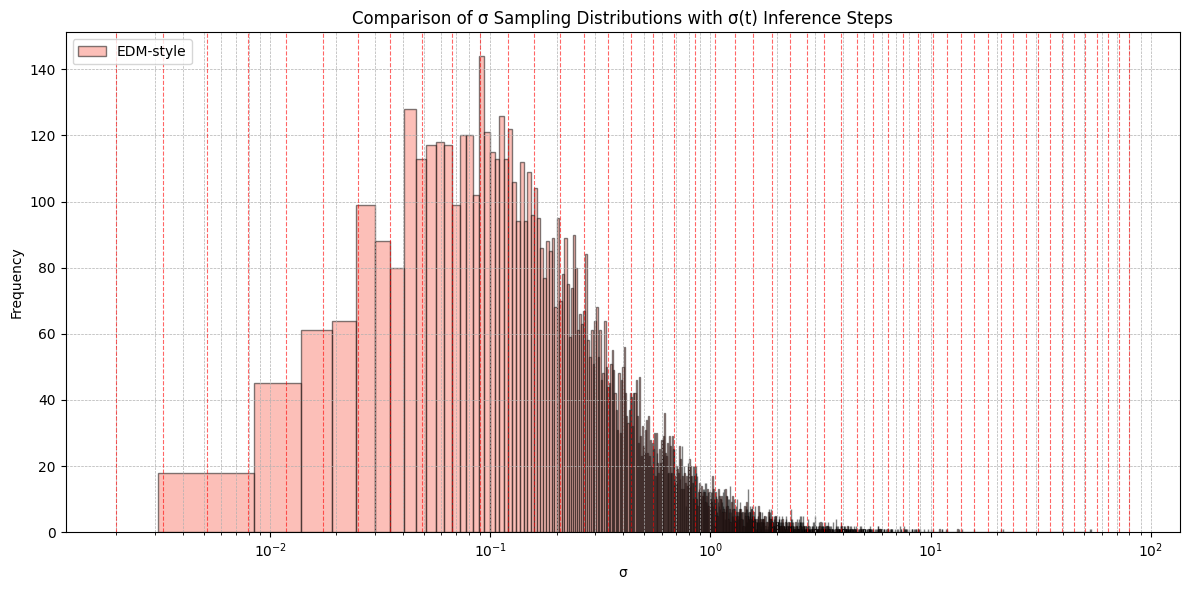

In [36]:
import torch
import matplotlib.pyplot as plt

# ------------------------------------------
# 하이퍼파라미터 및 t_steps 계산
inference_time_step = 50
sigma_min = 0.002
sigma_max = 80
rho = 7.0

step_indices = torch.arange(inference_time_step)
sigma_min_rho = sigma_min ** (1 / rho)
sigma_max_rho = sigma_max ** (1 / rho)
t_steps = (sigma_max_rho + step_indices / (inference_time_step - 1) * (sigma_min_rho - sigma_max_rho)) ** rho
t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])  # t_N = 0
t_steps_np = t_steps.numpy()

num_samples = 10000
# EDM-style Log-Normal
P_mean = -1.2
P_std = 1.2
log_sigma_edm = torch.randn(num_samples) * P_std + P_mean
sigma_edm = torch.exp(log_sigma_edm)

# ------------------------------------------
# 시각화
plt.figure(figsize=(12, 6))
plt.hist(sigma_edm.numpy(), bins=10000, alpha=0.5, color='salmon', edgecolor='black', label='EDM-style')

# inference σ(t) 위치 마킹
for sigma in t_steps_np:
    if sigma > 0:  # t_N = 0 이면 너무 왼쪽이라 제외
        plt.axvline(x=sigma, color='red', linestyle='--', linewidth=0.8, alpha=0.6)

plt.title("Comparison of σ Sampling Distributions with σ(t) Inference Steps")
plt.xlabel("σ")
plt.ylabel("Frequency")
plt.xscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.tight_layout()
plt.show()


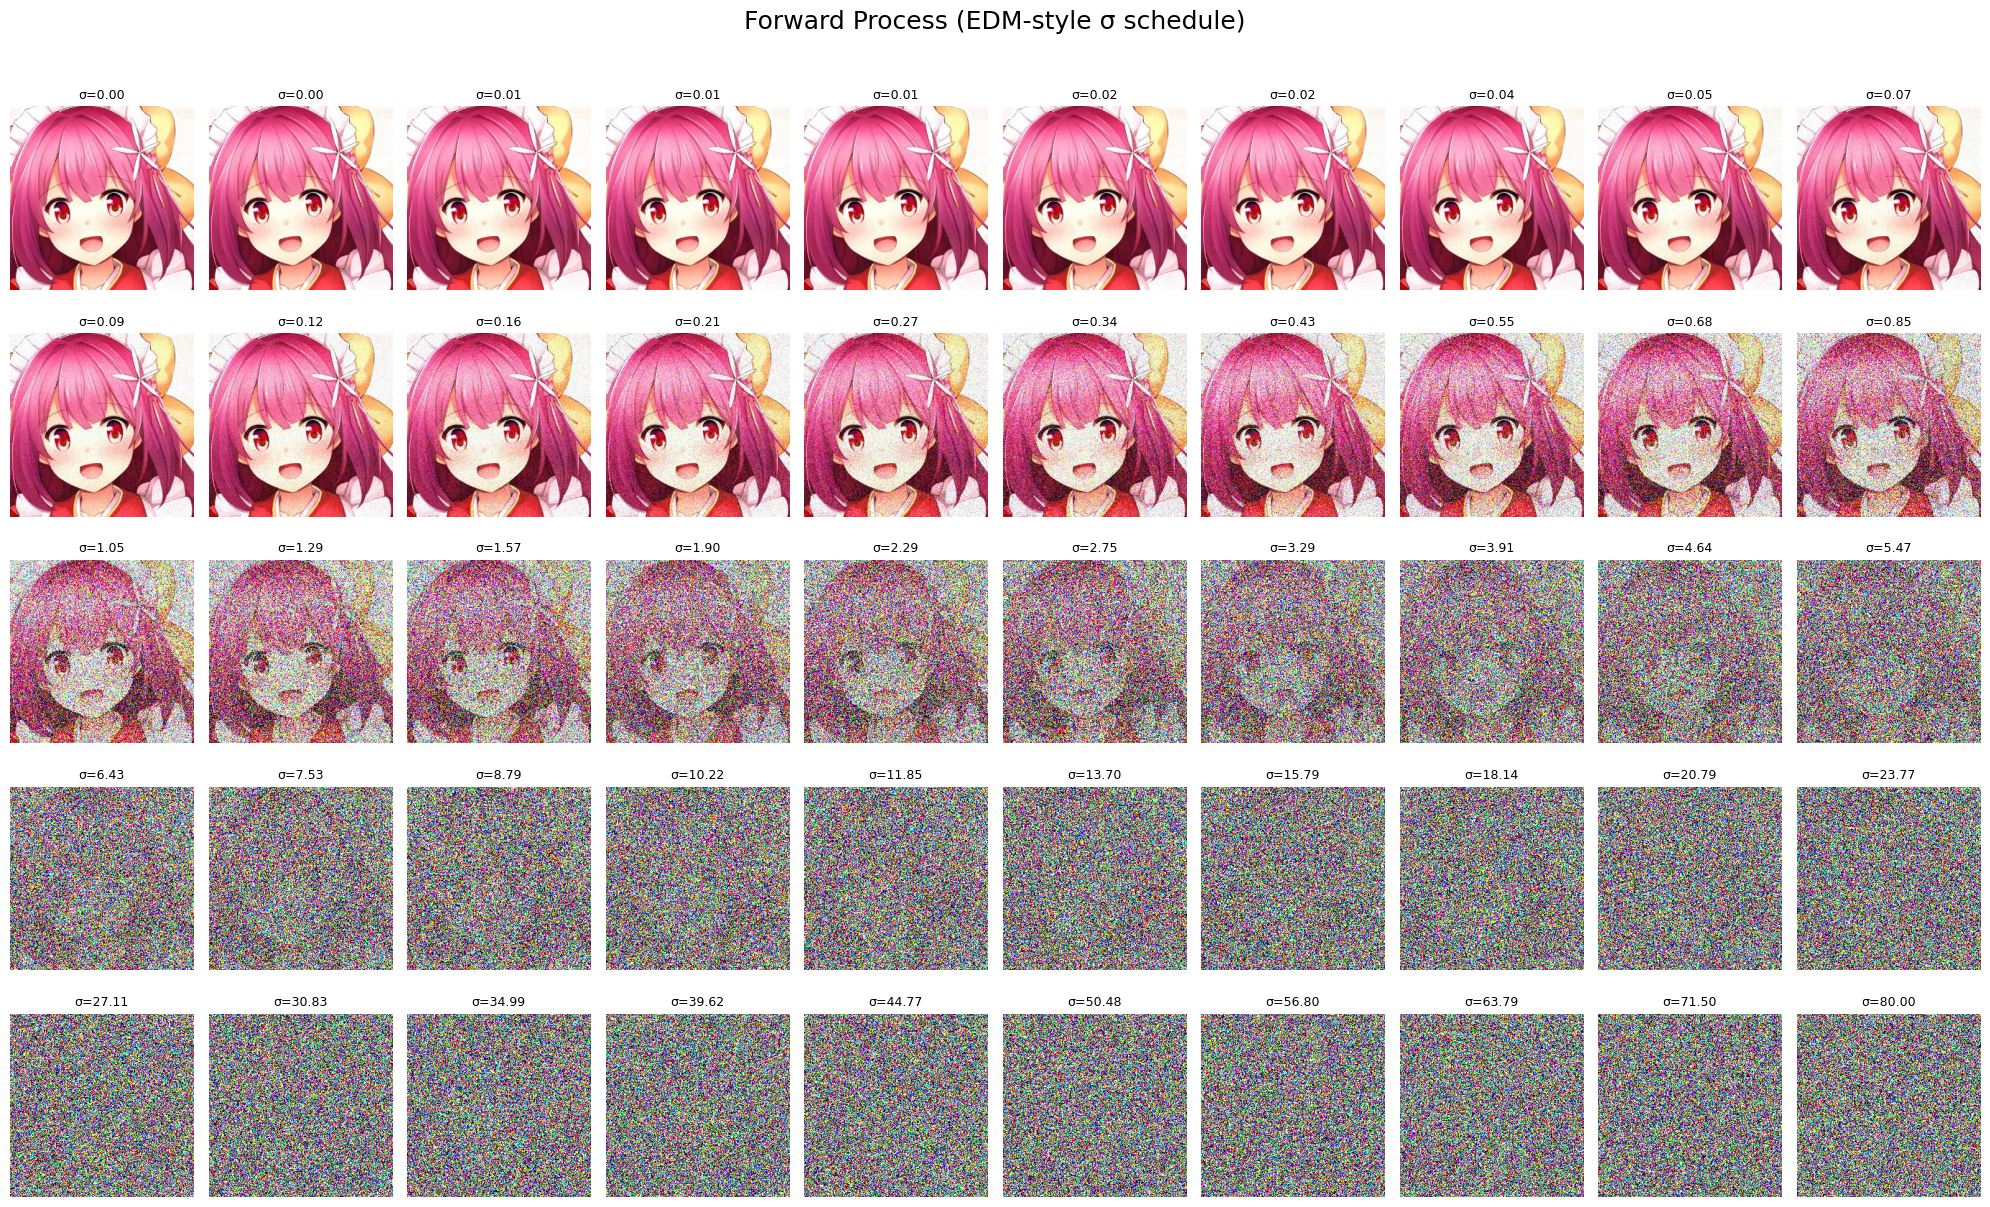

In [39]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# 설정
sigma_min = 0.002
sigma_max = 80
rho = 7
steps = 50

# EDM-style 스케줄
step_indices = torch.arange(steps)
sigma_min_rho = sigma_min ** (1 / rho)
sigma_max_rho = sigma_max ** (1 / rho)
sigmas = (sigma_max_rho + step_indices / (steps - 1) * (sigma_min_rho - sigma_max_rho)) ** rho
sigmas = sigmas.flip(0)

# 이미지 로딩 및 전처리
img_path = '/data/Anime/train_data/reference/'  # 경로 수정 필요
filename = sorted(os.listdir(img_path))[1]
img = Image.open(os.path.join(img_path, filename)).convert("RGB")

tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

x0 = tf(img).unsqueeze(0)  # [1, 3, H, W]

# 시각화 설정
rows = 5
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2.5 * rows))

for i in range(steps):
    sigma = sigmas[i].item()
    noise = torch.randn_like(x0) * sigma
    xt = (x0 + noise).clamp(-1, 1)
    xt = xt[0] * 0.5 + 0.5  # [-1,1] → [0,1]
    img_np = xt.permute(1, 2, 0).cpu().numpy()

    r = i // cols
    c = i % cols
    axes[r, c].imshow(img_np)
    axes[r, c].axis("off")
    axes[r, c].set_title(f"σ={sigma:.2f}", fontsize=9)

plt.suptitle("Forward Process (EDM-style σ schedule)", fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


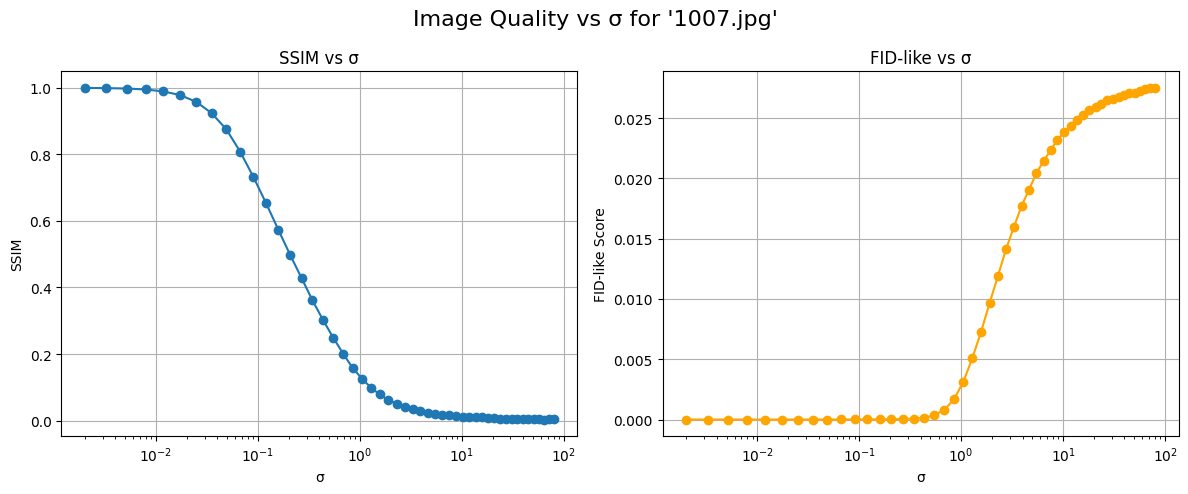

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

# 설정
img_path = '/data/Anime/train_data/reference/'  # 이미지 폴더 경로
sigma_min = 0.002
sigma_max = 80
rho = 7
steps = 50
image_size = 256

# EDM-style sigma 스케줄
step_indices = torch.arange(steps)
sigma_min_rho = sigma_min ** (1 / rho)
sigma_max_rho = sigma_max ** (1 / rho)
sigmas = (sigma_max_rho + step_indices / (steps - 1) * (sigma_min_rho - sigma_max_rho)) ** rho
sigmas = sigmas.flip(0)

# 첫 이미지 로딩
filename = sorted(os.listdir(img_path))[80]
img = Image.open(os.path.join(img_path, filename)).convert("RGB")

# 전처리
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
x0 = tf(img).unsqueeze(0)  # [1, 3, H, W]

# SSIM & FID-like 계산 함수
def compute_ssim(img1, img2):
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    return compare_ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

def compute_fid_like(x_real, x_fake):
    mu1, sigma1 = x_real.mean(), x_real.std()
    mu2, sigma2 = x_fake.mean(), x_fake.std()
    fid = (mu1 - mu2) ** 2 + (sigma1 - sigma2) ** 2
    return fid.item()

# 정규화 해제
x0_denorm = x0[0] * 0.5 + 0.5

# 메트릭 저장
ssim_scores = []
fid_scores = []

# 각 sigma에 대해 측정
for sigma in sigmas:
    noise = torch.randn_like(x0) * sigma
    xt = (x0 + noise).clamp(-1, 1)
    xt_denorm = xt[0] * 0.5 + 0.5
    ssim = compute_ssim(x0_denorm, xt_denorm)
    fid = compute_fid_like(x0_denorm, xt_denorm)
    ssim_scores.append(ssim)
    fid_scores.append(fid)

# 그래프 그리기
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sigmas.tolist(), ssim_scores, marker='o')
plt.title("SSIM vs σ")
plt.xlabel("σ")
plt.ylabel("SSIM")
plt.xscale("log")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(sigmas.tolist(), fid_scores, marker='o', color='orange')
plt.title("FID-like vs σ")
plt.xlabel("σ")
plt.ylabel("FID-like Score")
plt.xscale("log")
plt.grid(True)

plt.suptitle(f"Image Quality vs σ for '{filename}'", fontsize=16)
plt.tight_layout()
plt.show()

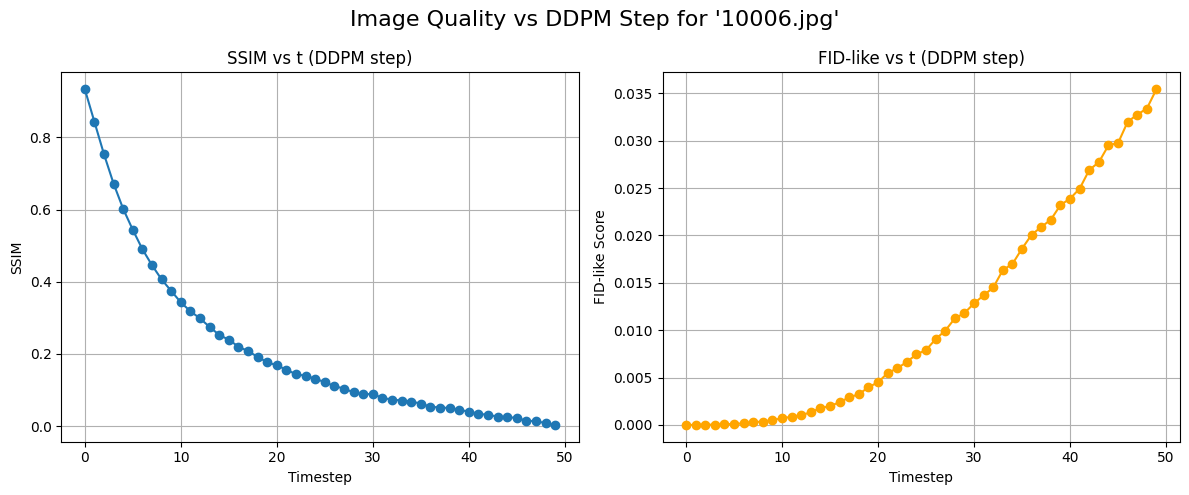

In [53]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img_path = '/data/Anime/train_data/reference/'  # 이미지 폴더 경로
filename = sorted(os.listdir(img_path))[10]
img = Image.open(os.path.join(img_path, filename)).convert("RGB")

# Cosine noise schedule
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * np.pi / 2) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # normalize
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(0, 0.999)

# --- 스케줄 생성 ---
T = 50
cos_betas = cosine_beta_schedule(T)
alphas = 1.0 - cos_betas
gammas = torch.cumprod(alphas, dim=0)

# --- forward ---
ssim_scores, fid_scores = [], []

with torch.no_grad():
    for gamma_t in gammas:
        gamma_t = gamma_t.item()
        noise = torch.randn_like(x0)
        xt = torch.sqrt(torch.tensor(gamma_t)) * x0 + torch.sqrt(torch.tensor(1 - gamma_t)) * noise
        xt = xt.clamp(-1, 1)
        xt_denorm = xt[0] * 0.5 + 0.5
        ssim = compute_ssim(x0_denorm, xt_denorm)
        fid = compute_fid_like(x0_denorm, xt_denorm)
        ssim_scores.append(ssim)
        fid_scores.append(fid)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(T), ssim_scores, marker='o')
plt.title("SSIM vs t (DDPM step)")
plt.xlabel("Timestep")
plt.ylabel("SSIM")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(T), fid_scores, marker='o', color='orange')
plt.title("FID-like vs t (DDPM step)")
plt.xlabel("Timestep")
plt.ylabel("FID-like Score")
plt.grid(True)

plt.suptitle(f"Image Quality vs DDPM Step for '{filename}'", fontsize=16)
plt.tight_layout()
plt.show()


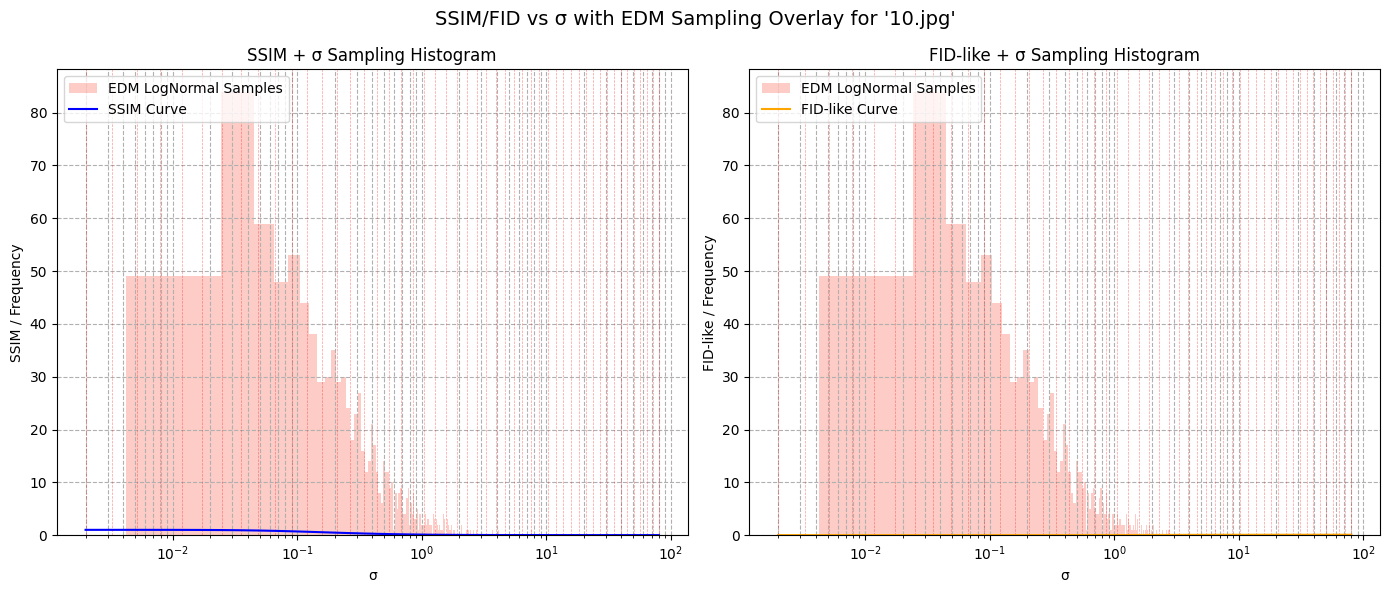

In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from skimage.metrics import structural_similarity as compare_ssim

# 설정
img_path = '/data/Anime/train_data/reference/'
filename = sorted(os.listdir(img_path))[1]
image_size = 256

sigma_min = 0.002
sigma_max = 80
rho = 7.0
inference_time_step = 50
eval_steps = 50
num_samples = 1000
P_mean = -1.5
P_std = 1.3

# 이미지 로딩 및 전처리
img = Image.open(os.path.join(img_path, filename)).convert("RGB")
tf = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
x0 = tf(img).unsqueeze(0)
x0_denorm = x0[0] * 0.5 + 0.5

# SSIM / FID-like 함수
def compute_ssim(img1, img2):
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    return compare_ssim(img1_np, img2_np, channel_axis=2, data_range=1.0)

def compute_fid_like(x_real, x_fake):
    mu1, sigma1 = x_real.mean(), x_real.std()
    mu2, sigma2 = x_fake.mean(), x_fake.std()
    return ((mu1 - mu2) ** 2 + (sigma1 - sigma2) ** 2).item()

# inference σ(t) 스케줄
step_indices = torch.arange(inference_time_step)
sigma_min_rho = sigma_min ** (1 / rho)
sigma_max_rho = sigma_max ** (1 / rho)
t_steps = (sigma_max_rho + step_indices / (inference_time_step - 1) * (sigma_min_rho - sigma_max_rho)) ** rho
t_steps = torch.cat([t_steps, torch.zeros_like(t_steps[:1])])
t_steps_np = t_steps.numpy()

# log-normal 기반 샘플링 분포
log_sigma_edm = torch.randn(num_samples) * P_std + P_mean
sigma_edm = torch.exp(log_sigma_edm)

# SSIM / FID 계산용 dense σ 리스트
eval_indices = torch.arange(eval_steps)
sigmas = (sigma_max_rho + eval_indices / (eval_steps - 1) * (sigma_min_rho - sigma_max_rho)) ** rho
sigmas = sigmas.flip(0)

ssim_scores = []
fid_scores = []

with torch.no_grad():
    for sigma in sigmas:
        noise = torch.randn_like(x0) * sigma
        xt = (x0 + noise).clamp(-1, 1)
        xt_denorm = xt[0] * 0.5 + 0.5
        ssim = compute_ssim(x0_denorm, xt_denorm)
        fid = compute_fid_like(x0_denorm, xt_denorm)
        ssim_scores.append(ssim)
        fid_scores.append(fid)

# 시각화
plt.figure(figsize=(14, 6))

# SSIM + σ 히스토그램
plt.subplot(1, 2, 1)
plt.hist(sigma_edm.numpy(), bins=500, alpha=0.4, color='salmon', label='EDM LogNormal Samples')
for sigma in t_steps_np:
    if sigma > 0:
        plt.axvline(x=sigma, color='red', linestyle='--', linewidth=0.5, alpha=0.4)
plt.plot(sigmas.numpy(), np.array(ssim_scores), color='blue', label='SSIM Curve')
plt.title("SSIM + σ Sampling Histogram")
plt.xlabel("σ")
plt.ylabel("SSIM / Frequency")
plt.xscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")

# FID + σ 히스토그램
plt.subplot(1, 2, 2)
plt.hist(sigma_edm.numpy(), bins=500, alpha=0.4, color='salmon', label='EDM LogNormal Samples')
for sigma in t_steps_np:
    if sigma > 0:
        plt.axvline(x=sigma, color='red', linestyle='--', linewidth=0.5, alpha=0.4)
plt.plot(sigmas.numpy(), np.array(fid_scores), color='orange', label='FID-like Curve')
plt.title("FID-like + σ Sampling Histogram")
plt.xlabel("σ")
plt.ylabel("FID-like / Frequency")
plt.xscale("log")
plt.legend()
plt.grid(True, which="both", ls="--")

plt.suptitle(f"SSIM/FID vs σ with EDM Sampling Overlay for '{filename}'", fontsize=14)
plt.tight_layout()
plt.show()
